In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

from data_loader import load_grid_search_data


In [9]:

def _vis_landscapes(
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None,
        converged_soln_markers=None,
    ):

    assert len(landscapes) == len(labels)
    assert len(landscapes) == len(params_paths)

    # plt.figure
    # plt.rc('font', size=28)
    if len(landscapes) == 2:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    elif len(landscapes) == 3:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    elif len(landscapes) == 4:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
    else:
        assert False

    fig.suptitle(title)
    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'])

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_title(labels[idx])
        axs[idx].set_xlabel('beta')
        axs[idx].set_ylabel('gamma')
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, linewidth=3, color='purple', label="optimization path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")

            if isinstance(converged_soln_markers, list):
                marker = converged_soln_markers[idx]
                if marker == '*':
                    markersize = 15
                elif marker == 'D':
                    markersize = 10
                
            else:
                marker = '*'
                markersize = 15

            axs[idx].plot(xs[-1], ys[-1], marker=marker,
                    color='red', markersize=markersize, label="converged solution")

            axs[idx].legend()

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))])
    # plt.legend()
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close('all')

4059
4059
8597
0.0345358675623616
0.010419894882019217
0.012795744149123314
0.003925111398555986


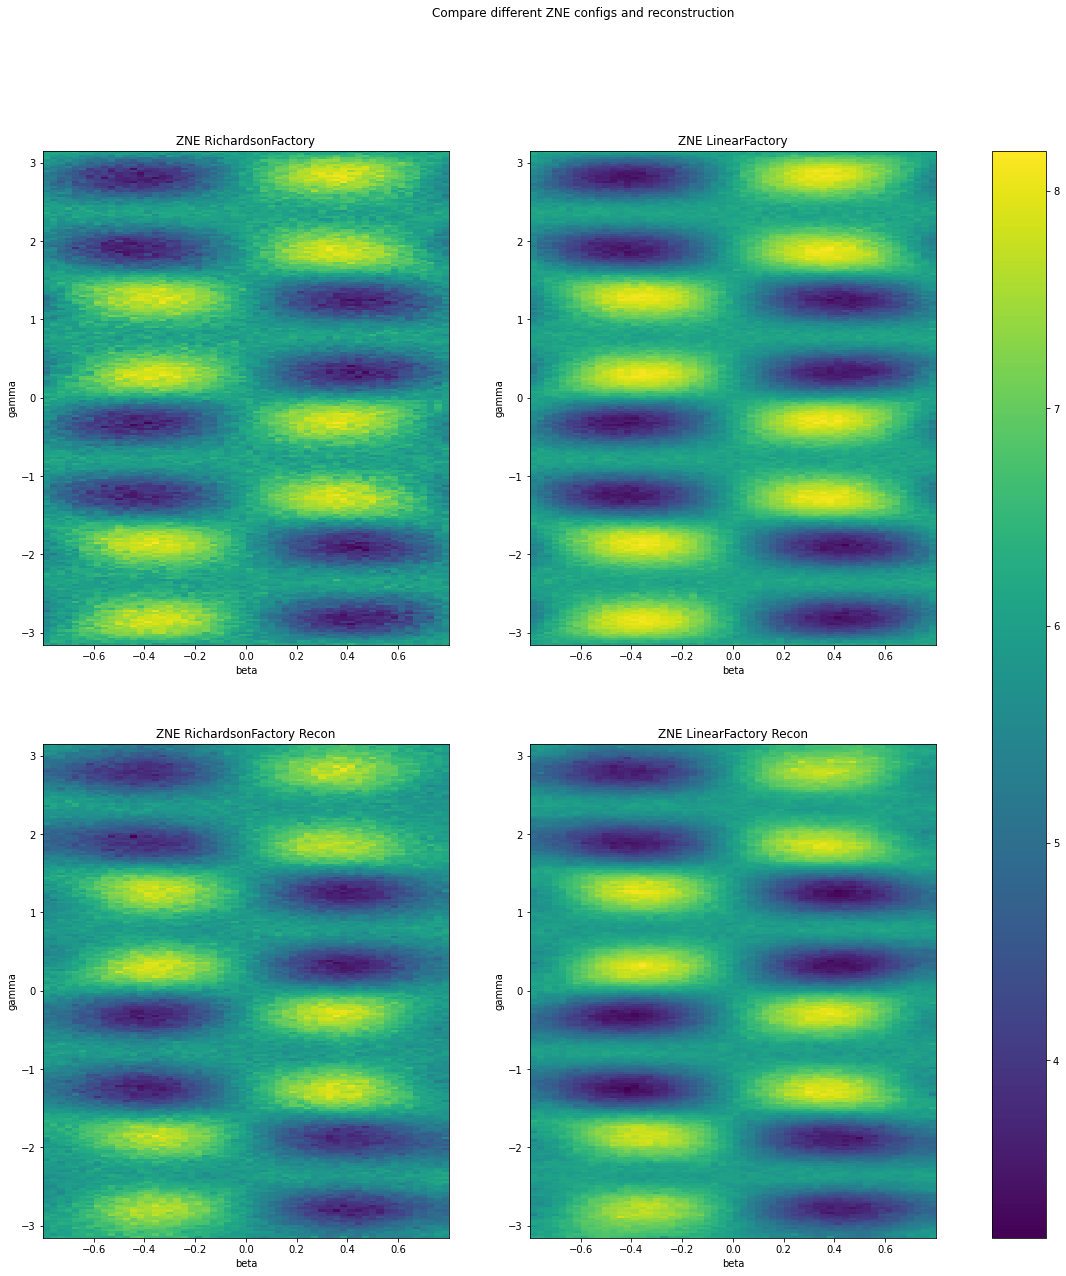

In [10]:
def vis_case_compare_mitigation_method():

    

    # derive origin full landscape
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()
    miti1 = origin['mitis']

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon_sf0.050.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()
    miti1_recon = recon['mitis']

    data2_dir = "figs/gen_p1_landscape/2022-10-08_16:52:53/G40_nQ8_p1_depolar0.001_0.005_zneLinear"
    miti2 = np.load(f"{data2_dir}/data.npz", allow_pickle=True)['origin'].tolist()['mitis']
    recon2_path = f"{data2_dir}/2D_CS_recon_sf0.050.npz"
    miti2_recon = np.load(recon2_path, allow_pickle=True)['recon'].tolist()['mitis']

    # params_paths = [opt_data2['params_path'].tolist(), opt_data2['params_path'].tolist(), opt_data1['params_path']]

    # find some points where Richardson Factory is closer

    ideal = origin['ideals']

    # recon.
    # diff1 = ideal - miti1_recon   # Richardson factory
    # diff2 = ideal - miti2_recon   # linear factory
    
    # origin
    diff1 = ideal - miti1   # Richardson factory
    diff2 = ideal - miti2   # linear factory

    ids = np.abs(diff1) < np.abs(diff2)     # indices that Richardson is closer to ideal than linear

    print(np.sum(ids))
    print(np.sum(ids == True))
    print(np.sum(ids == False))
    
    print(np.var(diff1))
    print(np.var(diff2))

    print(np.var(np.abs(diff1)))
    print(np.var(np.abs(diff2)))

    _vis_landscapes(
        # landscapes=[origin['unmitis'], miti1, miti2, miti1_recon, miti2_recon],
        landscapes=[miti1, miti2, miti1_recon, miti2_recon],
        labels=["ZNE RichardsonFactory", "ZNE LinearFactory", "ZNE RichardsonFactory Recon", "ZNE LinearFactory Recon"],
        full_range=full_range,
        true_optima=None,
        title="Compare different ZNE configs and reconstruction",
        save_path="paper_figs/case3.png",
        params_paths=[None, None, None, None]
    )
vis_case_compare_mitigation_method()

[0.0010727892143963524, 0.0010727892143964635] [0.00042852398205883713, 0.00042852398206139064] [0 1]


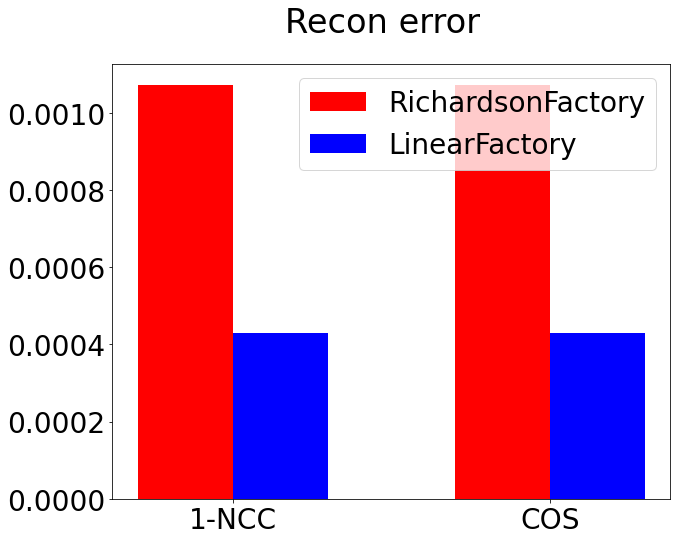

In [62]:
def vis_recon_error():
    # diff1 = {'L2-norm': 30.804969647723908, 'MSE': 0.2738246568786238, '1-NCC': 0.0010727892143963524, 'COS': 0.0010727892143964635}
    # diff2 = {'L2-norm': 19.65423771845724, 'MSE': 0.17470606077565495, '1-NCC': 0.00042852398205883713, 'COS': 0.00042852398206139064}
    
    diff1 = {'MSE': 0.2738246568786238, '1-NCC': 0.0010727892143963524, 'COS': 0.0010727892143964635}
    diff2 = {'MSE': 0.17470606077565495, '1-NCC': 0.00042852398205883713, 'COS': 0.00042852398206139064}
    
    diff1 = {'1-NCC': 0.0010727892143963524, 'COS': 0.0010727892143964635}
    diff2 = {'1-NCC': 0.00042852398205883713, 'COS': 0.00042852398206139064}

    # plt.rc('font', size=28)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    axs = [axs]
    fig.suptitle("Recon error")

    xs = np.array(range(len(diff1.keys())))
    labels = list(diff1.keys())
    val1s = list(diff1.values())
    val2s = list(diff2.values())
    print(val1s, val2s, xs)
    bar_width = 0.3
    axs[0].bar(xs, val1s, width=bar_width, label='RichardsonFactory', color="r")
    axs[0].bar(xs+bar_width, val2s, width=bar_width, label='LinearFactory', color="b")
    # axs[0].xticks(xs + bar_width/2, labels)
    axs[0].set_xticks(xs + bar_width/2)
    axs[0].set_xticklabels(labels)
    plt.legend()
    # axs[0].set_title("var of beta")

    plt.show()
vis_recon_error()

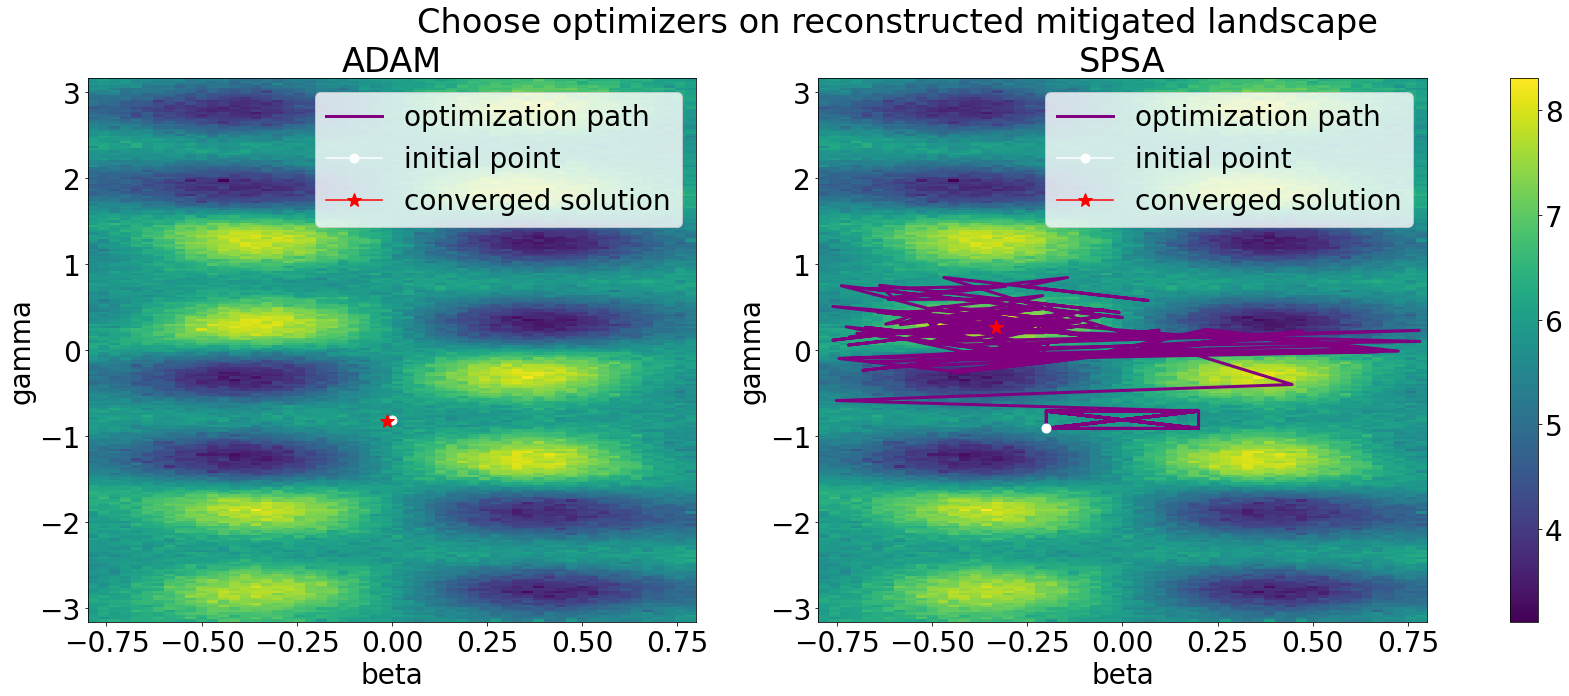

In [64]:
def vis_choose_optimizer():

    # derive origin full landscape
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    params1 = np.load("figs/opt_on_recon_landscape/2022-10-08_23:52:27/data.npz", allow_pickle=True)['params_path']
    params2 = np.load("figs/opt_on_recon_landscape/2022-10-08_23:55:28/data.npz", allow_pickle=True)['params_path']

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon_sf0.050.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()


    
    
    _vis_landscapes(
        landscapes=[recon["mitis"], recon["mitis"]],
        labels=["ADAM", "SPSA"],
        full_range=full_range,
        true_optima=None,
        title="Choose optimizers on reconstructed mitigated landscape",
        save_path="paper_figs/case4.png",
        params_paths=[params1, params2]
    )
vis_choose_optimizer()